# Fraud detection

In this notebook, we will attempt to understand and study an unbalanced data set containing fraudulent bank transactions. Our main goal will be to detect these undesirable transactions with as few errors as possible.

Our dataset comes from Kaggle, which can be found at the following URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

## Setting-Up

### Create and activate virtual environment
The first step is to set up the Python virtual environment, in first with the creation of the environnement, and then install dependencies using the [requirements.txt](requirements.txt) file.

In [ ]:
!python3 -m venv venv
!source venv/bin/activate
!pip install -r requirements.txt

### Imports

In [20]:
import os
import zipfile

import kaggle
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

### Download data from Kaggle

You can download the dataset either by using a Kaggle API key that you can configure in your account settings (see [here](https://github.com/Kaggle/kaggle-api/blob/main/docs/README.md#api-credentials)), or by downloading directly from the dataset page.

In [2]:
def download_data():
    if not os.path.exists("data"):
        kaggle.api.dataset_download_files("mlg-ulb/creditcardfraud")

        with zipfile.ZipFile("creditcardfraud.zip", "r") as zip_ref:
            zip_ref.extractall("data")

        zip_fraud_path = os.path.abspath("./creditcardfraud.zip")
        os.remove(zip_fraud_path)

In [3]:
download_data()

df = pd.read_csv("data/creditcard.csv")
TARGET_COLUMN_NAME = "Class"

## Data exploration

Exploring the data here isn't very instructive, because for reasons of anonymity, the bank data. The transactions have undergone a dimension reduction, which explains why the column names are not very explicit. However, we can already see the imbalance of our target class, namely the “Class” column, which is worth 1 if the transaction seems fraudulent, and 0 otherwise.

In [4]:
def get_df_info(p_df: pd.DataFrame):
    return p_df.info(), p_df[TARGET_COLUMN_NAME].value_counts()


get_df_info(p_df=df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

(None,
 Class
 0    284315
 1       492
 Name: count, dtype: int64)

In percentage terms, over 99% of transactions are regular. This could pose a problem when training our model, which could be confronted with problems of over-fitting to the negative class, and thus distorting the metrics. 

In [5]:
df[TARGET_COLUMN_NAME].value_counts(normalize=True)

Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

## Data processing

The solution is therefore to rebalance the dataset between negative and positive classes. For this, two methods are available: undersampling and oversampling.

### Undersampling

Undersampling consists in reducing the number of data items in the over-represented class - regular transactions - until the number of data items in the negative class is of the same order of magnitude as that in the positive class.    

In [6]:
def undersample(p_df: pd.DataFrame):
    df_non_fraud = p_df[p_df[TARGET_COLUMN_NAME] == 0]
    df_fraud = p_df[p_df[TARGET_COLUMN_NAME] == 1]

    df_non_fraud_undersampled = df_non_fraud.sample(df_fraud.shape[0],
                                                    random_state=42)

    df_balanced_undersampled = pd.concat([df_fraud, df_non_fraud_undersampled])
    df_balanced_undersampled[TARGET_COLUMN_NAME].value_counts()
    return df_balanced_undersampled


df_balanced_undersampled = undersample(df)
df_balanced_undersampled[TARGET_COLUMN_NAME].value_counts()

Class
1    492
0    492
Name: count, dtype: int64

We can now test the performance of a model, such as a DecisionTreeClassifier

In [7]:
def split_X_y(df_param: pd.DataFrame):
    X = df_param.drop(columns=[TARGET_COLUMN_NAME])
    y = df_param[TARGET_COLUMN_NAME]
    return X, y


def train_model_and_predict(df_param: pd.DataFrame) -> pd.Series:
    data, target = split_X_y(df_param)

    X_train, X_test, y_train, y_test = train_test_split(data,
                                                        target,
                                                        test_size=0.2,
                                                        random_state=42)

    dec_tree = DecisionTreeClassifier()

    dec_tree.fit(X_train, y_train)

    y_predict = dec_tree.predict(X_test)
    return y_test, y_predict, dec_tree

In [8]:
y_test, y_predict, dec_tree = train_model_and_predict(df_balanced_undersampled)

pd.DataFrame(confusion_matrix(y_test, y_predict))

,0,1
0,87,11
1,11,88


In [9]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89        98
           1       0.89      0.89      0.89        99

    accuracy                           0.89       197
   macro avg       0.89      0.89      0.89       197
weighted avg       0.89      0.89      0.89       197



We're already seeing good performance, with almost 90% good predictions on all classes, but now let's try oversampling to see if we get better diagnoses.

### Oversampling

Oversampling consists in artificially increasing the number of data items in the minority class, until it is of the same order of magnitude as the majority class. There are several ways of increasing the number of data items in the minority class; here, for example, we use the KMeans method.

In [10]:
def oversample(p_df: pd.DataFrame):
    X, y = split_X_y(p_df)
    smote = SMOTE()
    df_data_oversampled, df_target_oversampled = smote.fit_resample(X, y)
    return df_data_oversampled, df_target_oversampled


df_data_oversampled, df_target_oversampled = oversample(df)
df_target_oversampled.value_counts()

Class
0    284315
1    284315
Name: count, dtype: int64

In [11]:
df_oversampled = df_data_oversampled.assign(
    **{TARGET_COLUMN_NAME: df_target_oversampled})
y_test, y_predict, dec_tree = train_model_and_predict(df_oversampled)

In [12]:
pd.DataFrame(confusion_matrix(y_test, y_predict))

,0,1
0,56635,115
1,38,56938


In [13]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56750
           1       1.00      1.00      1.00     56976

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726



Oversampling enables us to obtain highly satisfactory results, with near-perfect class detection on the oversampled set.

Now let's try our trained model on the starting data. 

In [14]:
X, y = split_X_y(df)
y_predict = dec_tree.predict(X)

pd.DataFrame(confusion_matrix(y, y_predict))

,0,1
0,284200,115
1,2,490


In [15]:
print(classification_report(y, y_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.81      1.00      0.89       492

    accuracy                           1.00    284807
   macro avg       0.90      1.00      0.95    284807
weighted avg       1.00      1.00      1.00    284807



The performance of our model on the initial dataset is highly satisfactory: we have excellent recall on the positive class, with only 2 transactions misclassified out of 492 fraudulent transactions. However, the precision on the positive class is relatively low. Nevertheless, this is not too concerning, as the most important aspect is that all fraudulent transactions have been detected.

Here is the model's decision tree visualisation:

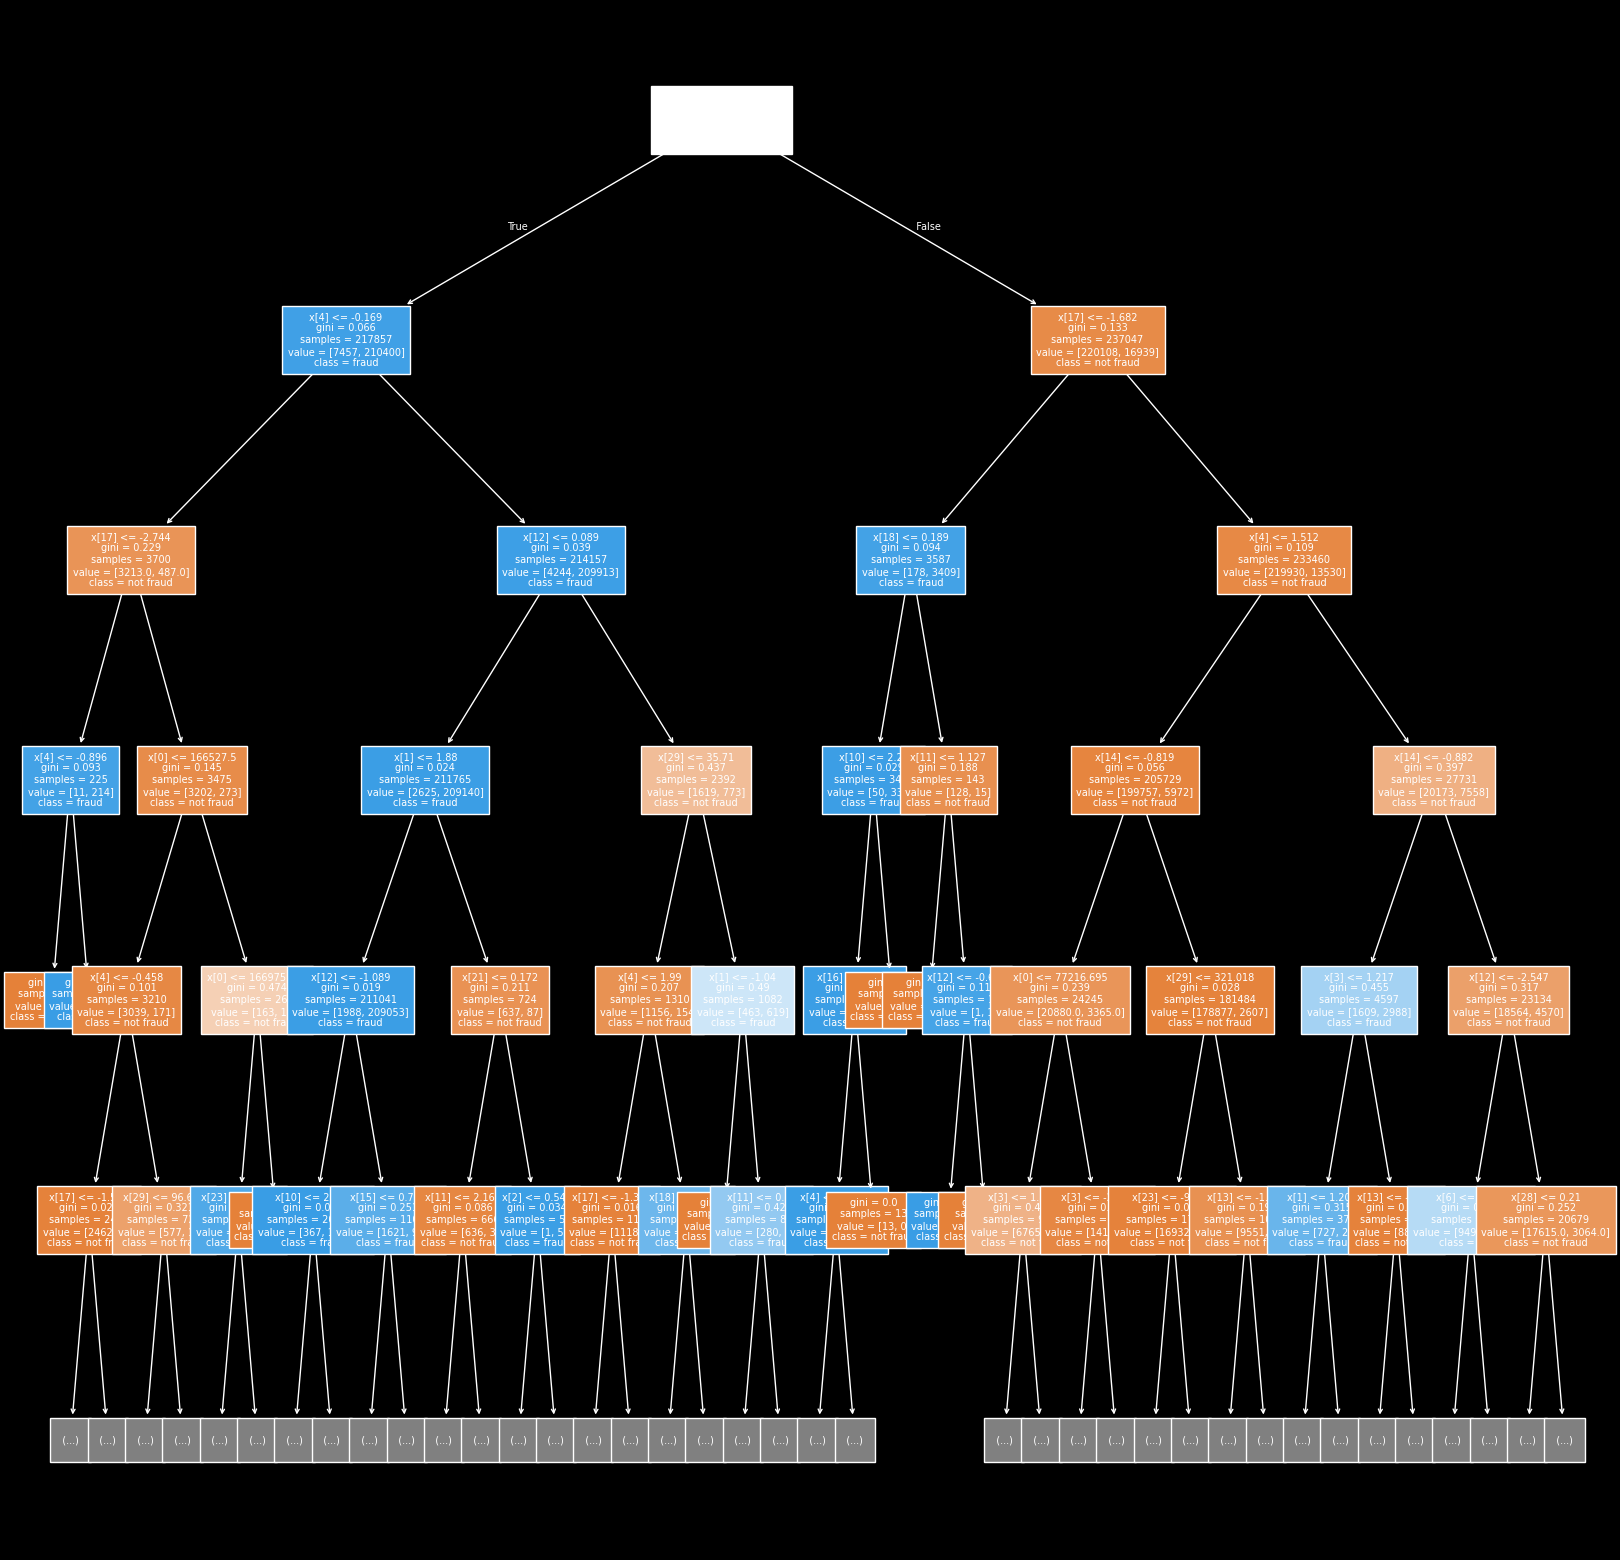

In [27]:
plt.figure(figsize=(20, 20))  # Ajuste la taille de la figure
plot_tree(dec_tree, filled=True, class_names=["not fraud","fraud"], max_depth=5, fontsize=7)
plt.show()